In [114]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

from neuropacks import PVC11
from noise_correlations import (analysis,
                                discriminability,
                                null_models,
                                utils,
                                plot)
from pratplot import colorbar as pcb

%matplotlib inline

In [2]:
# Load PVC11 dataset
base_path = '/Volumes/pss/data/pvc11/data/spikes_gratings'
data_path = os.path.join(base_path, 'data_monkey1_gratings.mat')
pack = PVC11(data_path)

In [3]:
# Get response matrix for PVC11 dataset, and stimuli
X = pack.get_response_matrix(transform=None)
stimuli = pack.get_design_matrix(form='angle')
# Delete neurons that don't response at all to a stimulus
X = np.delete(X, utils.get_nonresponsive_for_stim(X, stimuli), axis=1)
# Get units that are overall "responsive"
responsive_units = utils.get_responsive_units(
    X, stimuli, aggregator=np.mean,
    peak_response=10.)
X = X[:, responsive_units]

In [4]:
# Random state
rng = np.random.RandomState(2332)

In [5]:
dims = np.array([2, 5, 10, 15])

In [6]:
n_dims = dims.size
n_dimlets = 20
n_repeats = 1000
v_s_lfis = np.zeros((n_dims, n_dimlets * pack.n_stimuli, n_repeats))
v_s_sdkls = np.zeros_like(v_s_lfis)
v_r_lfis = np.zeros_like(v_s_lfis)
v_r_sdkls = np.zeros_like(v_s_lfis)
v_lfis = np.zeros((n_dims, n_dimlets * pack.n_stimuli))
v_sdkls = np.zeros_like(v_lfis)
units = {idx: np.zeros((n_dimlets * pack.n_stimuli, dim)) for idx, dim in enumerate(dims)}
stims = np.zeros((n_dims, n_dimlets * pack.n_stimuli, 2))

In [7]:
# Calculate null measures across dims
for idx, dim in enumerate(dims):
    print(idx)
    v_s_lfis[idx], v_s_sdkls[idx], v_r_lfis[idx], v_r_sdkls[idx], \
    v_lfis[idx], v_sdkls[idx], units[idx], stims[idx] = \
        analysis.calculate_null_measures(
            X, stimuli,
            n_dim=dim,
            n_dimlets=n_dimlets,
            rng=rng,
            n_repeats=n_repeats,
            circular_stim=True)

0
1
2
3


In [117]:
np.savez('rotations.npy', v_s_lfis, v_s_sdkls, v_r_lfis, v_r_sdkls, v_lfis, v_sdkls, units, stims)

In [8]:
# Calculate percentiles
p_r_lfi = 100 * np.mean(v_lfis[..., np.newaxis] > v_r_lfis, axis=2)
p_r_sdkl = 100 * np.mean(v_sdkls[..., np.newaxis] > v_r_sdkls, axis=2)

In [11]:
cov_dims = np.zeros_like(v_lfis)

In [14]:
for dim_idx, dim in enumerate(dims):
    for pair_idx in range(n_dimlets * 12):
        # second plot
        stim0_idx = np.argwhere(stimuli == stims[dim_idx, pair_idx, 0]).ravel()
        stim1_idx = np.argwhere(stimuli == stims[dim_idx, pair_idx, 1]).ravel()
        X0 = X[stim0_idx][:, units[dim_idx][pair_idx]]
        X1 = X[stim1_idx][:, units[dim_idx][pair_idx]]
        
        mu0, cov0 = utils.mean_cov(X0)
        mu1, cov1 = utils.mean_cov(X1)
        
        cov = (cov0 + cov1) / 2.
        u, _ = np.linalg.eigh(cov)
        cov_dims[dim_idx, pair_idx] = np.sum(u)**2 / np.sum(u**2)

Text(0, 0.5, '\\textbf{Participation Ratio}')

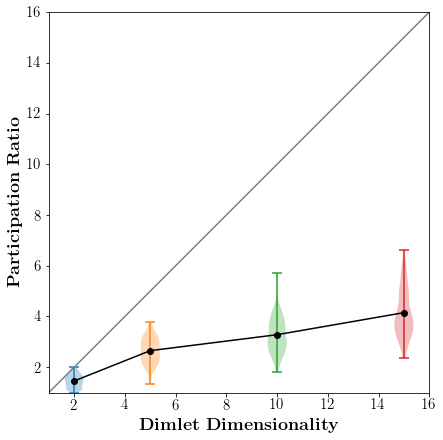

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
for idx, dim in enumerate(dims):
    ax.violinplot(cov_dims[idx], positions=[dim], widths=0.75)

ax.plot(dims, np.mean(cov_dims, axis=1), color='k', marker='o')
    
ax.set_xlim([1, 16])
ax.set_ylim([1, 16])
ax.plot(ax.get_xlim(), ax.get_ylim(), color='gray')
ax.set_aspect('equal')
ax.tick_params(labelsize=15)

ax.set_xlabel(r'\textbf{Dimlet Dimensionality}', fontsize=18)
ax.set_ylabel(r'\textbf{Participation Ratio}', fontsize=18)

In [86]:
cov_dims_avg = np.array([np.mean(np.array_split(cov_dims, 20, axis=1)[idx], axis=1) for idx in range(20)]).T

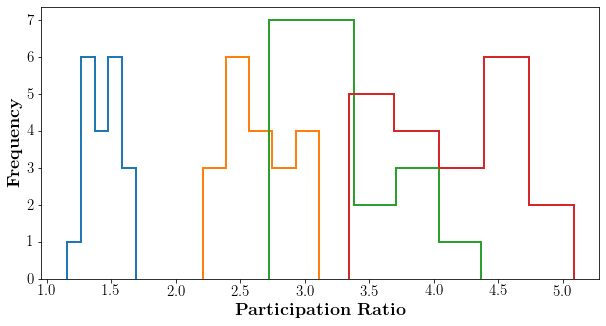

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for idx, dim in enumerate(dims):
    ax.hist(cov_dims_avg[idx],
            bins=5,
            histtype='step',
            linewidth=2,
            label=f'$d={dim}$')

ax.set_xlabel(r'\textbf{Participation Ratio}', fontsize=18)
ax.set_ylabel(r'\textbf{Frequency}', fontsize=18)
ax.tick_params(labelsize=15)

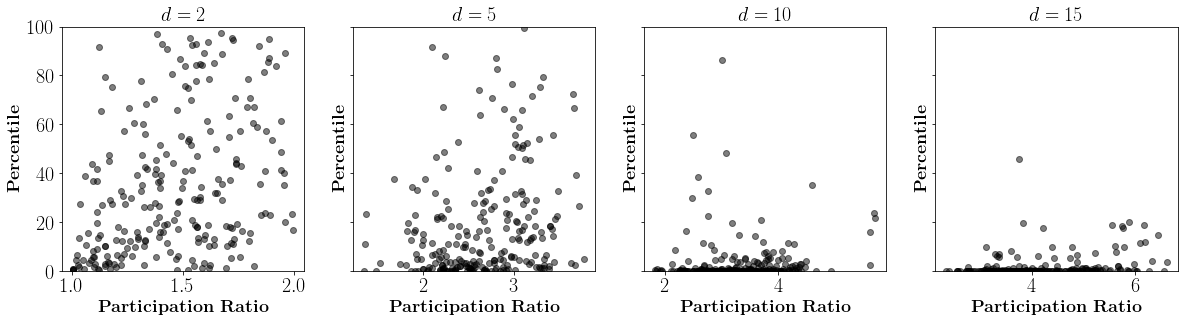

In [104]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4.5), sharey=True)

for idx, dim in enumerate(dims):
    axes[idx].scatter(cov_dims[idx], p_r_lfi[idx], color='black', alpha=0.5)
    
for idx, ax in enumerate(axes):
    ax.set_ylim([0, 100])
    ax.set_xlabel(r'\textbf{Participation Ratio}', fontsize=18)
    ax.set_ylabel(r'\textbf{Percentile}', fontsize=18)
    ax.set_title(f'$d={dims[idx]}$', fontsize=20)

In [110]:
us = np.linalg.eigh(cov)[0]

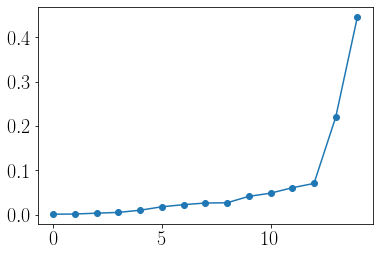

In [131]:
plt.plot(us / us.sum(), marker='o')

In [119]:
np.linalg.norm(mu0 - mu1)

14.53708275411542

In [125]:
np.mean(us) / 2

14.314152010050252

In [126]:
us/us.sum()

array([0.00087889, 0.00128873, 0.00323576, 0.00489159, 0.00984544,
       0.01762418, 0.02239011, 0.02609708, 0.02665354, 0.04111077,
       0.0483572 , 0.06057899, 0.07027417, 0.21994598, 0.44682757])

In [129]:
np.sum(np.array([0.5, 0.25, 0.10, 0.10,]))

0.95

In [130]:
0.05 / (15 - 4)

0.004545454545454546